# VARMA(p,q)
## Vector Autoregressive Moving Average
This lesson picks up where VAR(p) left off.

Recall that the system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$.<br>
Most importantly, $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

In a <strong>VARMA(p,q)</strong> model we give the error terms $\varepsilon_t$ a moving average representation of order $q$.


### Formulation
We've seen that an autoregressive moving average ARMA(p,q) model is described by the following:

&nbsp;&nbsp;&nbsp;&nbsp; $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$

A $K$-dimensional VARMA model of order $(p,q)$ considers each variable $y_K$ in the system.<br>

For example, the system of equations for a 2-dimensional VARMA(1,1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \theta_{11,1}\varepsilon_{1,t-1} + \theta_{12,1}\varepsilon_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \theta_{21,1}\varepsilon_{1,t-1} + \theta_{22,1}\varepsilon_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\theta_{ii,l}$ captures the influence of the $l$th lag of error $\varepsilon_i$ on itself,<br>
the coefficient $\theta_{ij,l}$ captures the influence of the $l$th lag of error $\varepsilon_j$ on $\varepsilon_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are residual white noise.<br>


The general steps involved in building a VARMA model are:
* Examine the data
* Visualize the data
* Test for stationarity
* If necessary, transform the data to make it stationary
* Select the appropriate <em>p</em> and <em>q</em> orders
* Instantiate the model and fit it to a training set
* If necessary, invert the earlier transformation
* Evaluate model predictions against a known test set
* Forecast the future

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.api import VAR #, DynamicVAR
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('Dataset\M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('Dataset\PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [4]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


# Plot dataset

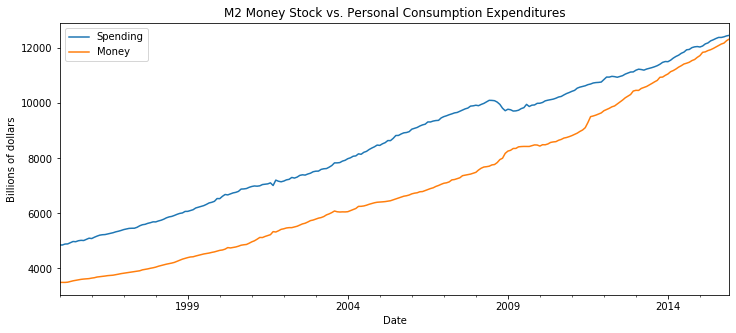

In [12]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

# Test Stationary

In [13]:
# INCLUDED HERE IF YOU CHOOSE TO USE IT
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [14]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, order=(3, 2, 3))

In [15]:
auto_arima(df['Spending'],maxiter=1000)


ARIMA(maxiter=1000, order=(1, 1, 2))

It looks like a VARMA(1,2) model is recommended. Note that the $d$ term (2 for Money, 1 for Spending) is about to be addressed by transforming the data to make it stationary. As before we'll apply a second order difference.

In [16]:
# Apply second order difference
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [17]:
len(df_transformed)

250

# Train Test Split

In [18]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

# Fit VARMA(1,2) Model

In [19]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.447
,+ intercept,AIC,4606.893
Date:,"Mon, 06 Jul 2020",BIC,4665.922
Time:,18:01:13,HQIC,4630.683
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"68.79, 29.07",Jarque-Bera (JB):,"531.15, 111.27"
Prob(Q):,"0.00, 0.90",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.50, 2.95",Skew:,"1.31, -0.33"


# Predict and Test

In [20]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-10.375569,35.980409
2015-02-01,-10.861774,-3.490345
2015-03-01,0.558236,-0.414062
2015-04-01,-1.304272,-0.227828
2015-05-01,0.690588,0.096772
2015-06-01,-0.157780,0.019517
2015-07-01,0.352445,0.083739
2015-08-01,0.089242,0.054279
2015-09-01,0.234035,0.071369
2015-10-01,0.156553,0.062423


# Invert predicted values

In [21]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [23]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11659.724431,12097.980409
2015-02-01,11852.4,12082.4,11648.862657,12094.490064
2015-03-01,11868.8,12158.3,11649.420892,12094.076002
2015-04-01,11916.1,12193.8,11648.116620,12093.848174
2015-05-01,11947.6,12268.1,11648.807209,12093.944946
2015-06-01,11993.1,12308.3,11648.649429,12093.964463
2015-07-01,12045.3,12355.4,11649.001874,12094.048202
2015-08-01,12096.8,12394.0,11649.091116,12094.102481
2015-09-01,12153.8,12392.8,11649.325151,12094.173850


# Plot prediction and test

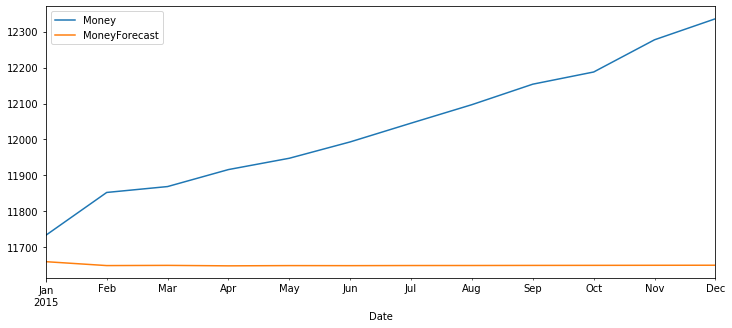

In [24]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

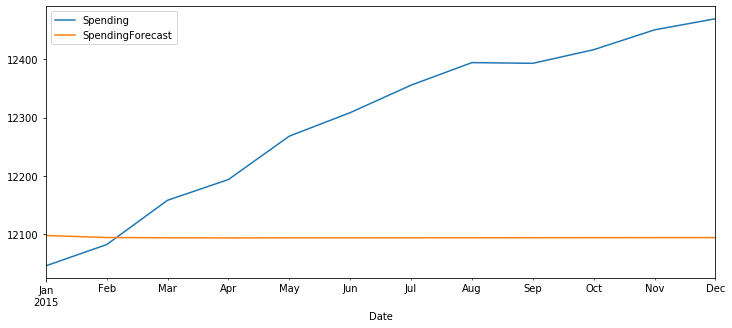

In [25]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

# Evaluate model

In [26]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Money VAR(5) RMSE: 422.399
Spending VAR(5) RMSE: 243.459


# Compare with individual ARMA(1,2) models

In [27]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

In [28]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [5]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from statsmodels.tools.eval_measures import rmse

## ETS Decomposition

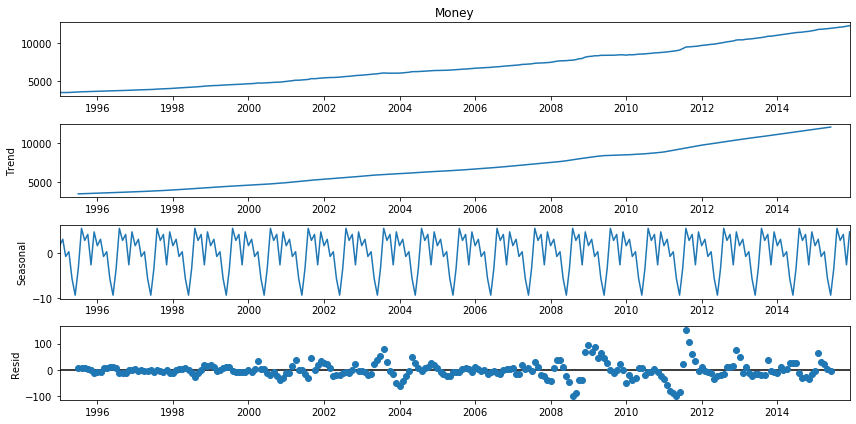

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
result = seasonal_decompose(df['Money'], model='add')
result.plot();

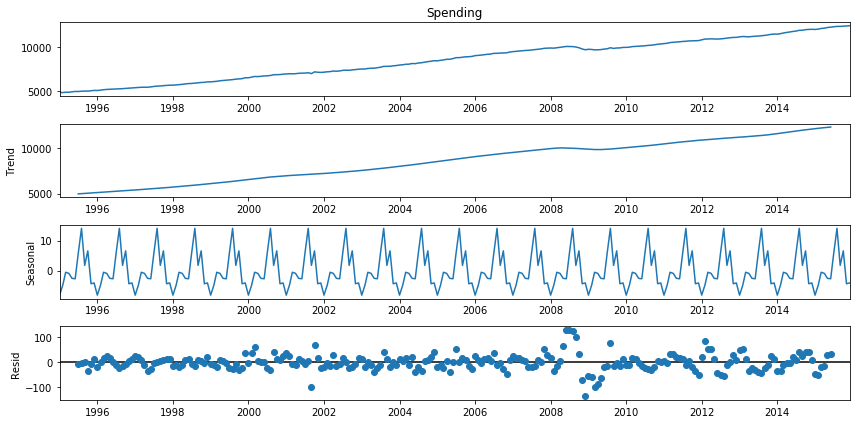

In [7]:
result = seasonal_decompose(df['Spending'], model='add')
result.plot();

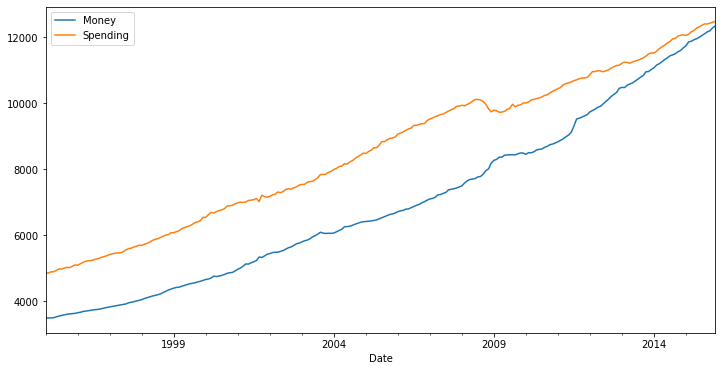

In [8]:
df.plot(legend=True, figsize=(12,6))

There is no obvious seasonality

In [9]:
auto_arima(df['Money'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1166.143
Date:                Mon, 06 Jul 2020   AIC                           2348.286
Time:                        18:11:09   BIC                           2376.457
Sample:                             0   HQIC                          2359.624
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3814      0.084      4.525      0.000       0.216       0.547
ar.L1         -0.7924      0.039    -20.433      0.000      -0.868      -0.716
ar.L2         -0.6273      0.049    -12.749      0.000      -0.724      -0.531
ar.L3          0.2993      0.038      7.954      0.000       0.226       0.373
ma.L1          0.0530      0.800      0.066      0.947      -1.515       1.621
ma.L2         -0.0806      0.839     -0.096      0.923      -1.726       1.565
ma.L3         -0.9718      0.782     -1.243      0.214      -2.504       0.560
sigma2       643.2768    527.318      1.220      0.223    -390.247    1676.800
===================================================================================
Ljung-Box (Q):                       59.45   Jarque-Bera (JB):               503.14
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               4.75   Skew:                             1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
auto_arima(df['Spending'],seasonal=False).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1238.601
Date:                Mon, 06 Jul 2020   AIC                           2487.202
Time:                        18:11:30   BIC                           2504.829
Sample:                             0   HQIC                          2494.295
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7215      3.525      1.907      0.057      -0.187      13.630
ar.L1          0.7775      0.120      6.470      0.000       0.542       1.013
ma.L1         -0.7890      0.117     -6.767      0.000      -1.017      -0.560
ma.L2          0.1342      0.062      2.171      0.030       0.013       0.255
sigma2      1131.1348     61.856     18.286      0.000    1009.898    1252.371
===================================================================================
Ljung-Box (Q):                       34.25   Jarque-Bera (JB):               216.24
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.30
Prob(H) (two-sided):                  0.92   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Split Train Test set

In [11]:
df.shape

(252, 2)

In [12]:
nobs=12
train_Money, test_Money = df[0:-nobs]['Money'], df[-nobs:]['Money']

In [13]:
train_Spending, test_Spending = df[0:-nobs]['Spending'], df[-nobs:]['Spending']

## Create SARIMAX(3, 2, 3) for Money; Evaluate

In [14]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults # load models

In [15]:
model = ARIMA(train_Money,order=(3, 2, 3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Money   No. Observations:                  238
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -1108.971
Method:                       css-mle   S.D. of innovations             25.055
Date:                Mon, 06 Jul 2020   AIC                           2233.942
Time:                        18:16:58   BIC                           2261.720
Sample:                    03-01-1995   HQIC                          2245.137
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1824      0.034      5.323      0.000       0.115       0.250
ar.L1.D2.Money    -0.7968      0.063    -12.706      0.000      -0.920      -0.674
ar.L2.D2.Money    -0.6313      0.070     -9.020      0.000      -0.768      -0.494
ar.L3.D2.Money     0.3185      0.062      5.144      0.000       0.197       0.440
ma.L1.D2.Money     0.0944        nan        nan        nan         nan         nan
ma.L2.D2.Money    -0.0944      0.007    -13.235      0.000      -0.108      -0.080
ma.L3.D2.Money    -1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5644           -0.8311j            1.0046           -0.3449
AR.2           -0.5644           +0.8311j            1.0046            0.3449
AR.3            3.1106           -0.0000j            3.1106           -0.0000
MA.1           -0.5472           -0.8370j            1.0000           -0.3422
MA.2           -0.5472           +0.8370j            1.0000            0.3422
MA.3            1.0000           -0.0000j            1.0000           -0.0000
-----------------------------------------------------------------------------
"""

In [17]:
# Obtain predicted values
start=len(train_Money)
end=len(train_Money)+len(test_Money)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3, 2, 3) Money Predictions')

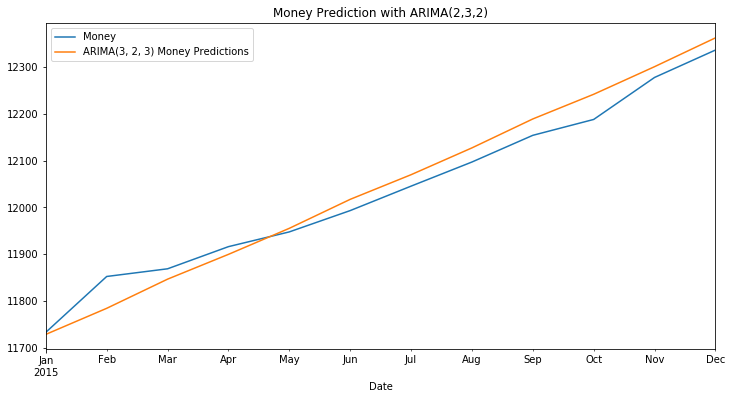

In [18]:
ax = test_Money.plot(legend=True,figsize=(12,6),title='Money Prediction with ARIMA(2,3,2)')
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True);

In [20]:
error = rmse(test_Money, predictions)
print(f'ARIMA(3,2,3) RMSE Error: {error:11.10}')

ARIMA(3,2,3) RMSE Error: 32.73487332


## Create SARIMAX(1, 1, 2) for Spending

In [22]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults # load models

model = ARIMA(train_Spending,order=(1, 1, 2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.Spending   No. Observations:                  239
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1181.357
Method:                       css-mle   S.D. of innovations             33.910
Date:                Mon, 06 Jul 2020   AIC                           2372.714
Time:                        18:21:05   BIC                           2390.097
Sample:                    02-01-1995   HQIC                          2379.719
                         - 12-01-2014                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               30.1074      3.463      8.694      0.000      23.320      36.894
ar.L1.D.Spending     0.7864      0.153      5.142      0.000       0.487       1.086
ma.L1.D.Spending    -0.8096      0.160     -5.068      0.000      -1.123      -0.496
ma.L2.D.Spending     0.1499      0.071      2.104      0.035       0.010       0.289
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2717           +0.0000j            1.2717            0.0000
MA.1            1.9119           +0.0000j            1.9119            0.0000
MA.2            3.4897           +0.0000j            3.4897            0.0000
-----------------------------------------------------------------------------
"""

In [23]:
# Obtain predicted values
start=len(train_Spending)
end=len(train_Spending)+len(test_Spending)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1, 1,2 ) Spending Predictions')

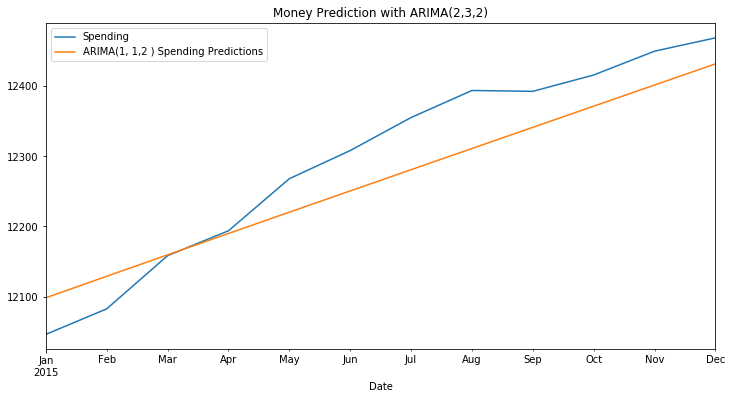

In [24]:
ax = test_Spending.plot(legend=True,figsize=(12,6),title='Money Prediction with ARIMA(2,3,2)')
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True);

In [26]:
error = rmse(test_Spending, predictions)
print(f'ARIMA(1,1,2) RMSE Error: {error:11.10}')

ARIMA(1,1,2) RMSE Error:  51.0120931


<strong>CONCLUSION:</strong> It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.